# Data cleaning and handling

In [1]:
#ICTRP Search: "covid-19" or "novel coronavirus" or "2019-ncov" or "covid19" or "sars-cov-2"
import xmltodict
import pandas as pd
import numpy as np
from datetime import date
import unicodedata

#POINT THIS TO THE UPDATED XML
#with open('ICTRP-Results_18Mar2020.xml', 'rb') as f:
#    xml = xmltodict.parse(f, dict_constructor=dict)

#df = pd.DataFrame(xml['Trials_downloaded_from_ICTRP']['Trial'])


df = pd.read_excel('covid-19-trials_25Mar2020.xlsx', dtype={'Phase': str})

#UPDATE THESE WITH EACH RUN
prior_extract_date = date(2020,3,18)
this_extract_date = date(2020,3,25)

In [2]:
#For future:
#Can try and parse the 'Target_size' variable, difficult for the Chinese registry

cols = ['TrialID', 'Source Register', 'Date registration', 'Date enrollement', 'Primary sponsor', 
        'Recruitment Status', 'Phase', 'Study type', 'Countries', 'Public title', 'Intervention',
        'web address', 'results url link', 'Last Refreshed on']

df_cond = df[cols].reset_index(drop=True)

df_cond.columns = ['TrialID', 'Source_Register', 'Date_registration', 'Date_enrollement', 
                   'Primary_sponsor', 'Recruitment_Status', 'Phase', 'Study_type', 'Countries', 
                   'Public_title', 'Intervention', 'web_address', 'results_url_link', 
                   'Last_Refreshed_on']

print(f'Search on ICTRP reveals {len(df_cond)} trials as of {this_extract_date}')

Search on ICTRP reveals 667 trials as of 2020-03-25


In [3]:
#POINT THIS TO LAST WEEK'S DATA
last_weeks_trials = pd.read_csv('trial_data_18_mar.csv')

df_cond = df_cond.merge(last_weeks_trials[['trialid', 'first_seen']], left_on = 'TrialID', right_on = 'trialid', 
                        how='left').drop('trialid', axis=1)

In [4]:
#For next time
df_cond['first_seen'] = pd.to_datetime(df_cond['first_seen'].fillna(this_extract_date))

In [5]:
#Check for which registries we are dealing with:
df_cond.Source_Register.value_counts()

ChiCTR                             524
ClinicalTrials.gov                 121
IRCT                                 8
JPRN                                 5
EU Clinical Trials Register          3
TCTR                                 2
ISRCTN                               2
Netherlands Trial Register           1
German Clinical Trials Register      1
Name: Source_Register, dtype: int64

This is the first area where we may need manual intervention on updates. As more registries start to appear, there may be dates in new formats that we need to address. Just running a date parse over the column, even with just two registries, was already producing wonky dates so I had to split it by registry. Check this based on the registries above and adjust.

It looks like this is now standardized well enough in the ICTRP excel file that pandas can parse right on loading

#last refreshed date parse
df_cond['Last_Refreshed_on'] = pd.to_datetime(df_cond['Last_Refreshed_on'])

#cleaning up registration dates

date_parsing_reg = df_cond[['TrialID', 'Date_registration']].reset_index(drop=True)

ncts = date_parsing_reg[date_parsing_reg['TrialID'].str.contains('NCT')].reset_index(drop=True)
ncts['parsed_date'] = pd.to_datetime(ncts['Date_registration'], format='%d/%m/%Y')

chictr = date_parsing_reg[date_parsing_reg['TrialID'].str.contains('Chi')].reset_index(drop=True)
chictr['parsed_date'] = pd.to_datetime(chictr['Date_registration'], format='%Y-%m-%d')

nct_merged_reg = df_cond.merge(ncts[['TrialID','parsed_date']], on='TrialID', how='left')
chi_merged_reg = nct_merged_reg.merge(chictr[['TrialID','parsed_date']], on='TrialID', how='left')

df_cond['Date_registration'] = chi_merged_reg['parsed_date_x'].fillna(chi_merged_reg['parsed_date_y'])

#cleaning up start dates

date_parsing_enr = df_cond[['TrialID', 'Date_enrollement']].reset_index(drop=True)

ncts = date_parsing_enr[date_parsing_enr['TrialID'].str.contains('NCT')].reset_index(drop=True)
ncts['parsed_date'] = pd.to_datetime(ncts['Date_enrollement'])

chictr = date_parsing_enr[date_parsing_enr['TrialID'].str.contains('Chi')].reset_index(drop=True)
chictr['parsed_date'] = pd.to_datetime(chictr['Date_enrollement'], format='%Y-%m-%d')

nct_merged_enr = df_cond.merge(ncts[['TrialID','parsed_date']], on='TrialID', how='left')
chi_merged_enr = nct_merged_enr.merge(chictr[['TrialID','parsed_date']], on='TrialID', how='left')

df_cond['Date_enrollement'] = chi_merged_enr['parsed_date_x'].fillna(chi_merged_enr['parsed_date_y'])

In [6]:
#lets get rid of trials from before 2020 for now

pre_2020 = len(df_cond[df_cond['Date_registration'] < pd.Timestamp(2020,1,1)])

print(f'Excluded {pre_2020} trials from before 2020')

df_cond_rec = df_cond[df_cond['Date_registration'] >= pd.Timestamp(2020,1,1)].reset_index(drop=True)

print(f'{len(df_cond_rec)} trials remain')

Excluded 1 trials from before 2020
666 trials remain


Point 2 for manual intervention. As more registries add trials, we will have to contend with a wider vocabulary/identification methods for trials that are cancelled/withdrawn.

No further conflicts as of 25 Mar 2020

In [7]:
#Removing cancelled/withdrawn trials for what registries we have to date

cancelled_trials = len(df_cond_rec[(df_cond_rec['Public_title'].str.contains('Cancelled')) | 
                         (df_cond_rec['Recruitment_Status'] == "Withdrawn")])

print(f'Excluded {cancelled_trials} cancelled trials with no enrollment')

df_cond_nc = df_cond_rec[~(df_cond_rec['Public_title'].str.contains('Cancelled')) & 
                         ~(df_cond_rec['Recruitment_Status'] == "Withdrawn")].reset_index(drop=True)

print(f'{len(df_cond_nc)} trials remain')

Excluded 41 cancelled trials with no enrollment
625 trials remain


Point three for manual intervention. All this normalisation and data cleaning will have to be expanded each update as more trials get added and more registries start to add trials with their own idiosyncratic data categories. 

In [8]:
#Now lets get rid of ones we know don't belong from manual review

exclude = ['NCT04226157']

df_cond_nc = df_cond_nc[~df_cond_nc['TrialID'].isin(exclude)].reset_index(drop=True)

In [ ]:
def check_fields(field):
    return df_cond_nc[field].unique()

#Check fields for new unique values that require normalisation
check_fields('Study_type')

In [ ]:
check_fields('Countries')

In [9]:
#More data cleaning

#Can't have nulls in the results field. Might need to move this later on when we start populating results
df_cond_nc['results_url_link'] = df_cond_nc['results_url_link'].fillna('No Results')

#semi-colons in the intervention field mess with CSV
df_cond_nc['Intervention'] = df_cond_nc['Intervention'].str.replace(';', '')

#phase
df_cond_nc['Phase'] = df_cond_nc['Phase'].fillna('Not Applicable')
phase_fixes = {'0':'Not Applicable', '1':'Phase 1', '2':'Phase 2', '3':'Phase 3', '4':'Phase 4', 
               '1-2':'Phase 1/Phase 2', 'Retrospective study':'Not Applicable', 
               'Not applicable':'Not Applicable',
               'New Treatment Measure Clinical Study':'Not Applicable', 
               '2020-02-01 00:00:00':'Phase 1/Phase 2',
               '2020-03-02 00:00:00':'Phase 2/Phase 3', 'Phase III':'Phase 3',
               'Human pharmacology (Phase I): no\nTherapeutic exploratory (Phase II): yes\nTherapeutic confirmatory - (Phase III): no\nTherapeutic use (Phase IV): no\n': 'Phase 2',
               'Human pharmacology (Phase I): no\nTherapeutic exploratory (Phase II): no\nTherapeutic confirmatory - (Phase III): yes\nTherapeutic use (Phase IV): no\n': 'Phase 3'
              }
df_cond_nc['Phase'] = df_cond_nc['Phase'].replace(phase_fixes)

#Study Type
obv_replace = ['Observational [Patient Registry]', 'observational']
int_replace = ['interventional', 'Interventional clinical trial of medicinal product', 'Treatment']

df_cond_nc['Study_type'] = df_cond_nc['Study_type'].str.replace(' study', '')
df_cond_nc['Study_type'] = df_cond_nc['Study_type'].replace(obv_replace, 'Observational')
df_cond_nc['Study_type'] = df_cond_nc['Study_type'].replace(int_replace, 'Interventional')

#Recruitment Status
df_cond_nc['Recruitment_Status'] = df_cond_nc['Recruitment_Status'].replace('Not recruiting', 'Not Recruiting')
df_cond_nc['Recruitment_Status'] = df_cond_nc['Recruitment_Status'].fillna('No Status Given')

#Get rid of messy accents

def norm_names(x):
    normed = unicodedata.normalize('NFKD', str(x)).encode('ASCII', 'ignore').decode()
    return normed 

df_cond_nc['Primary_sponsor'] = df_cond_nc.Primary_sponsor.apply(norm_names)
df_cond_nc['Primary_sponsor'] = df_cond_nc['Primary_sponsor'].replace('NA', 'No Sponsor Name Given')
df_cond_nc['Primary_sponsor'] = df_cond_nc['Primary_sponsor'].replace('nan', 'No Sponsor Name Given')

In [10]:
#Countries
df_cond_nc['Countries'] = df_cond_nc['Countries'].fillna('No Country Given')

china_corr = ['Chian', 'China?', 'Chinese', 'Wuhan', 'Chinaese', 'china']

country_values = df_cond_nc['Countries'].tolist()

new_list = []

for c in country_values:
    country_list = []
    if isinstance(c, float):
        country_list.append('No Sponsor Name Given')
    elif c in china_corr:
        country_list.append('China')
    elif c == 'Iran (Islamic Republic of)':
        country_list.append('Iran')
    elif c == 'Korea, Republic of':
        country_list.append('South Korea')
    elif c == 'Japan,Asia(except Japan),Australia,Europe':
        country_list = ['Japan', 'Australia', 'Asia', 'Europe']
    elif ';' in c:
        c_list = c.split(';')
        unique_values = list(set(c_list))
        for v in unique_values:
            if v == 'Iran (Islamic Republic of)':
                country_list.append('Iran')
            elif v == 'Korea, Republic of':
                country_list.append('South Korea')
            else:
                country_list.append(v)
    else:
        country_list.append(c)
    new_list.append(', '.join(country_list))

df_cond_nc['Countries'] = new_list

Last space for manual intervention. This will include manual normalisation of new names, any updates to the normalisation schedule from the last update, and updating manually-coded intervention type data.

In [12]:
#Normalizing sponsor names
#Run this cell, updating the spon_norm csv you are loading after manual adjusting
#until you get the 'All sponsor names normalized' to print

spon_norm = pd.read_csv('norm_schedule_25Mar2020.csv')

df_cond_norm = df_cond_nc.merge(spon_norm, left_on = 'Primary_sponsor', right_on ='unique_spon_names', how='left')
df_cond_norm = df_cond_norm.drop('unique_spon_names', axis=1)

new_unique_spon_names = (df_cond_norm[df_cond_norm['normed_spon_names'].isna()][['Primary_sponsor', 'TrialID']]
                        .groupby('Primary_sponsor').count())

if len(new_unique_spon_names) > 0:
    new_unique_spon_names.to_csv('to_norm.csv')
    print('Update the normalisation schedule and rerun')
else:
    print('All sponsor names normalized')

All sponsor names normalized


In [ ]:
#interim dataset

col_names = []

for col in list(df_cond_norm.columns):
    col_names.append(col.lower())
    
df_cond_norm.columns = col_names

reorder = ['trialid', 'source_register', 'date_registration', 'date_enrollement', 'normed_spon_names', 
           'recruitment_status', 'phase', 'study_type', 'countries', 'public_title',
           'web_address', 'results_url_link', 'last_refreshed_on', 'first_seen']

df_cond_norm[reorder].to_csv('trial_data_25_mar.csv')

In [13]:
mar18 = pd.read_csv('trial_data_18_mar.csv')
mar18['results_url_link'] = mar18['results_url_link'].fillna('No Results')
mar18['phase'] = mar18['phase'].fillna('Not Applicable')
mar18['recruitment_status'] = mar18['recruitment_status'].fillna('No Status Given')

In [ ]:
import json
with open("trials_18mar.json", "w") as f:
    json.dump({"data": mar18.values.tolist()}, f, indent=2)

In [ ]:
#Integrating intervention type data
#Once again, run to bring in the old int-type data, islolate the new ones, update, and rerun until
#producing the all-clear message

int_type = pd.read_csv('int_type_data_8mar2020.csv')
df_cond_int = df_cond_norm.merge(int_type, left_on = 'TrialID', right_on = 'trial_id', how='left')
df_cond_int = df_cond_int.drop('trial_id', axis=1)

new_int_trials = df_cond_int[df_cond_int['intervention_type'].isna()]

if len(new_int_trials) > 0:
    new_int_trials[['TrialID', 'Public_title', 'Intervention', 'intervention_type']].to_csv('int_to_assess.csv')
    print('Update the intervention type assessments and rerun')
else:
    print('All intervention types matched')

In [ ]:
#take a quick glance at old trials that updated

df_cond_int[(df_cond_int['Last_Refreshed_on'] > pd.Timestamp(prior_extract_date)) & 
            (df_cond_int['first_seen'] != this_extract_date)]

In [ ]:
col_names = []

for col in list(df_cond_int.columns):
    col_names.append(col.lower())
    
df_cond_int.columns = col_names

reorder = ['trialid', 'source_register', 'date_registration', 'date_enrollement', 'normed_spon_names', 
           'recruitment_status', 'phase', 'study_type', 'countries', 'public_title', 'intervention_type', 
           'web_address', 'results_url_link', 'last_refreshed_on', 'first_seen']

df_final = df_cond_int[reorder].reset_index(drop=True)

In [ ]:
#df_final.to_csv(f'trial_list_{this_extract_date}.csv')

In [ ]:
df_final.head()

# Overall Trend in Registered Trials Graph

In [24]:
#just_reg = df_final[['trialid', 'date_registration']].reset_index(drop=True)
just_reg = mar18[['trialid', 'date_registration']].reset_index(drop=True)
just_reg['date_registration'] = pd.to_datetime(just_reg['date_registration'], format='%d/%m/%Y')

#catch old registrations that were expanded to include COVID, we can get rid of these for now
just_reg = just_reg[just_reg['date_registration'] >= pd.Timestamp(2020,1,1)].reset_index(drop=True)


In [25]:
just_reg.head(50)

,trialid,date_registration
0,ChiCTR2000029953,2020-02-17
1,ChiCTR2000029935,2020-02-16
2,ChiCTR2000029868,2020-02-15
3,ChiCTR2000029850,2020-02-15
4,ChiCTR2000029814,2020-02-14
5,ChiCTR2000029805,2020-02-14
6,ChiCTR2000029789,2020-02-13
7,ChiCTR2000029782,2020-02-13
8,ChiCTR2000029764,2020-02-13
9,ChiCTR2000029695,2020-02-10


In [26]:
just_reg.index = just_reg['date_registration']


grouped = just_reg.resample('W').count()
cumsum = grouped.cumsum()

In [29]:
grouped.head()

,trialid,date_registration
date_registration,,
2020-01-26,3,3
2020-02-02,37,37
2020-02-09,50,50
2020-02-16,88,88
2020-02-23,95,95


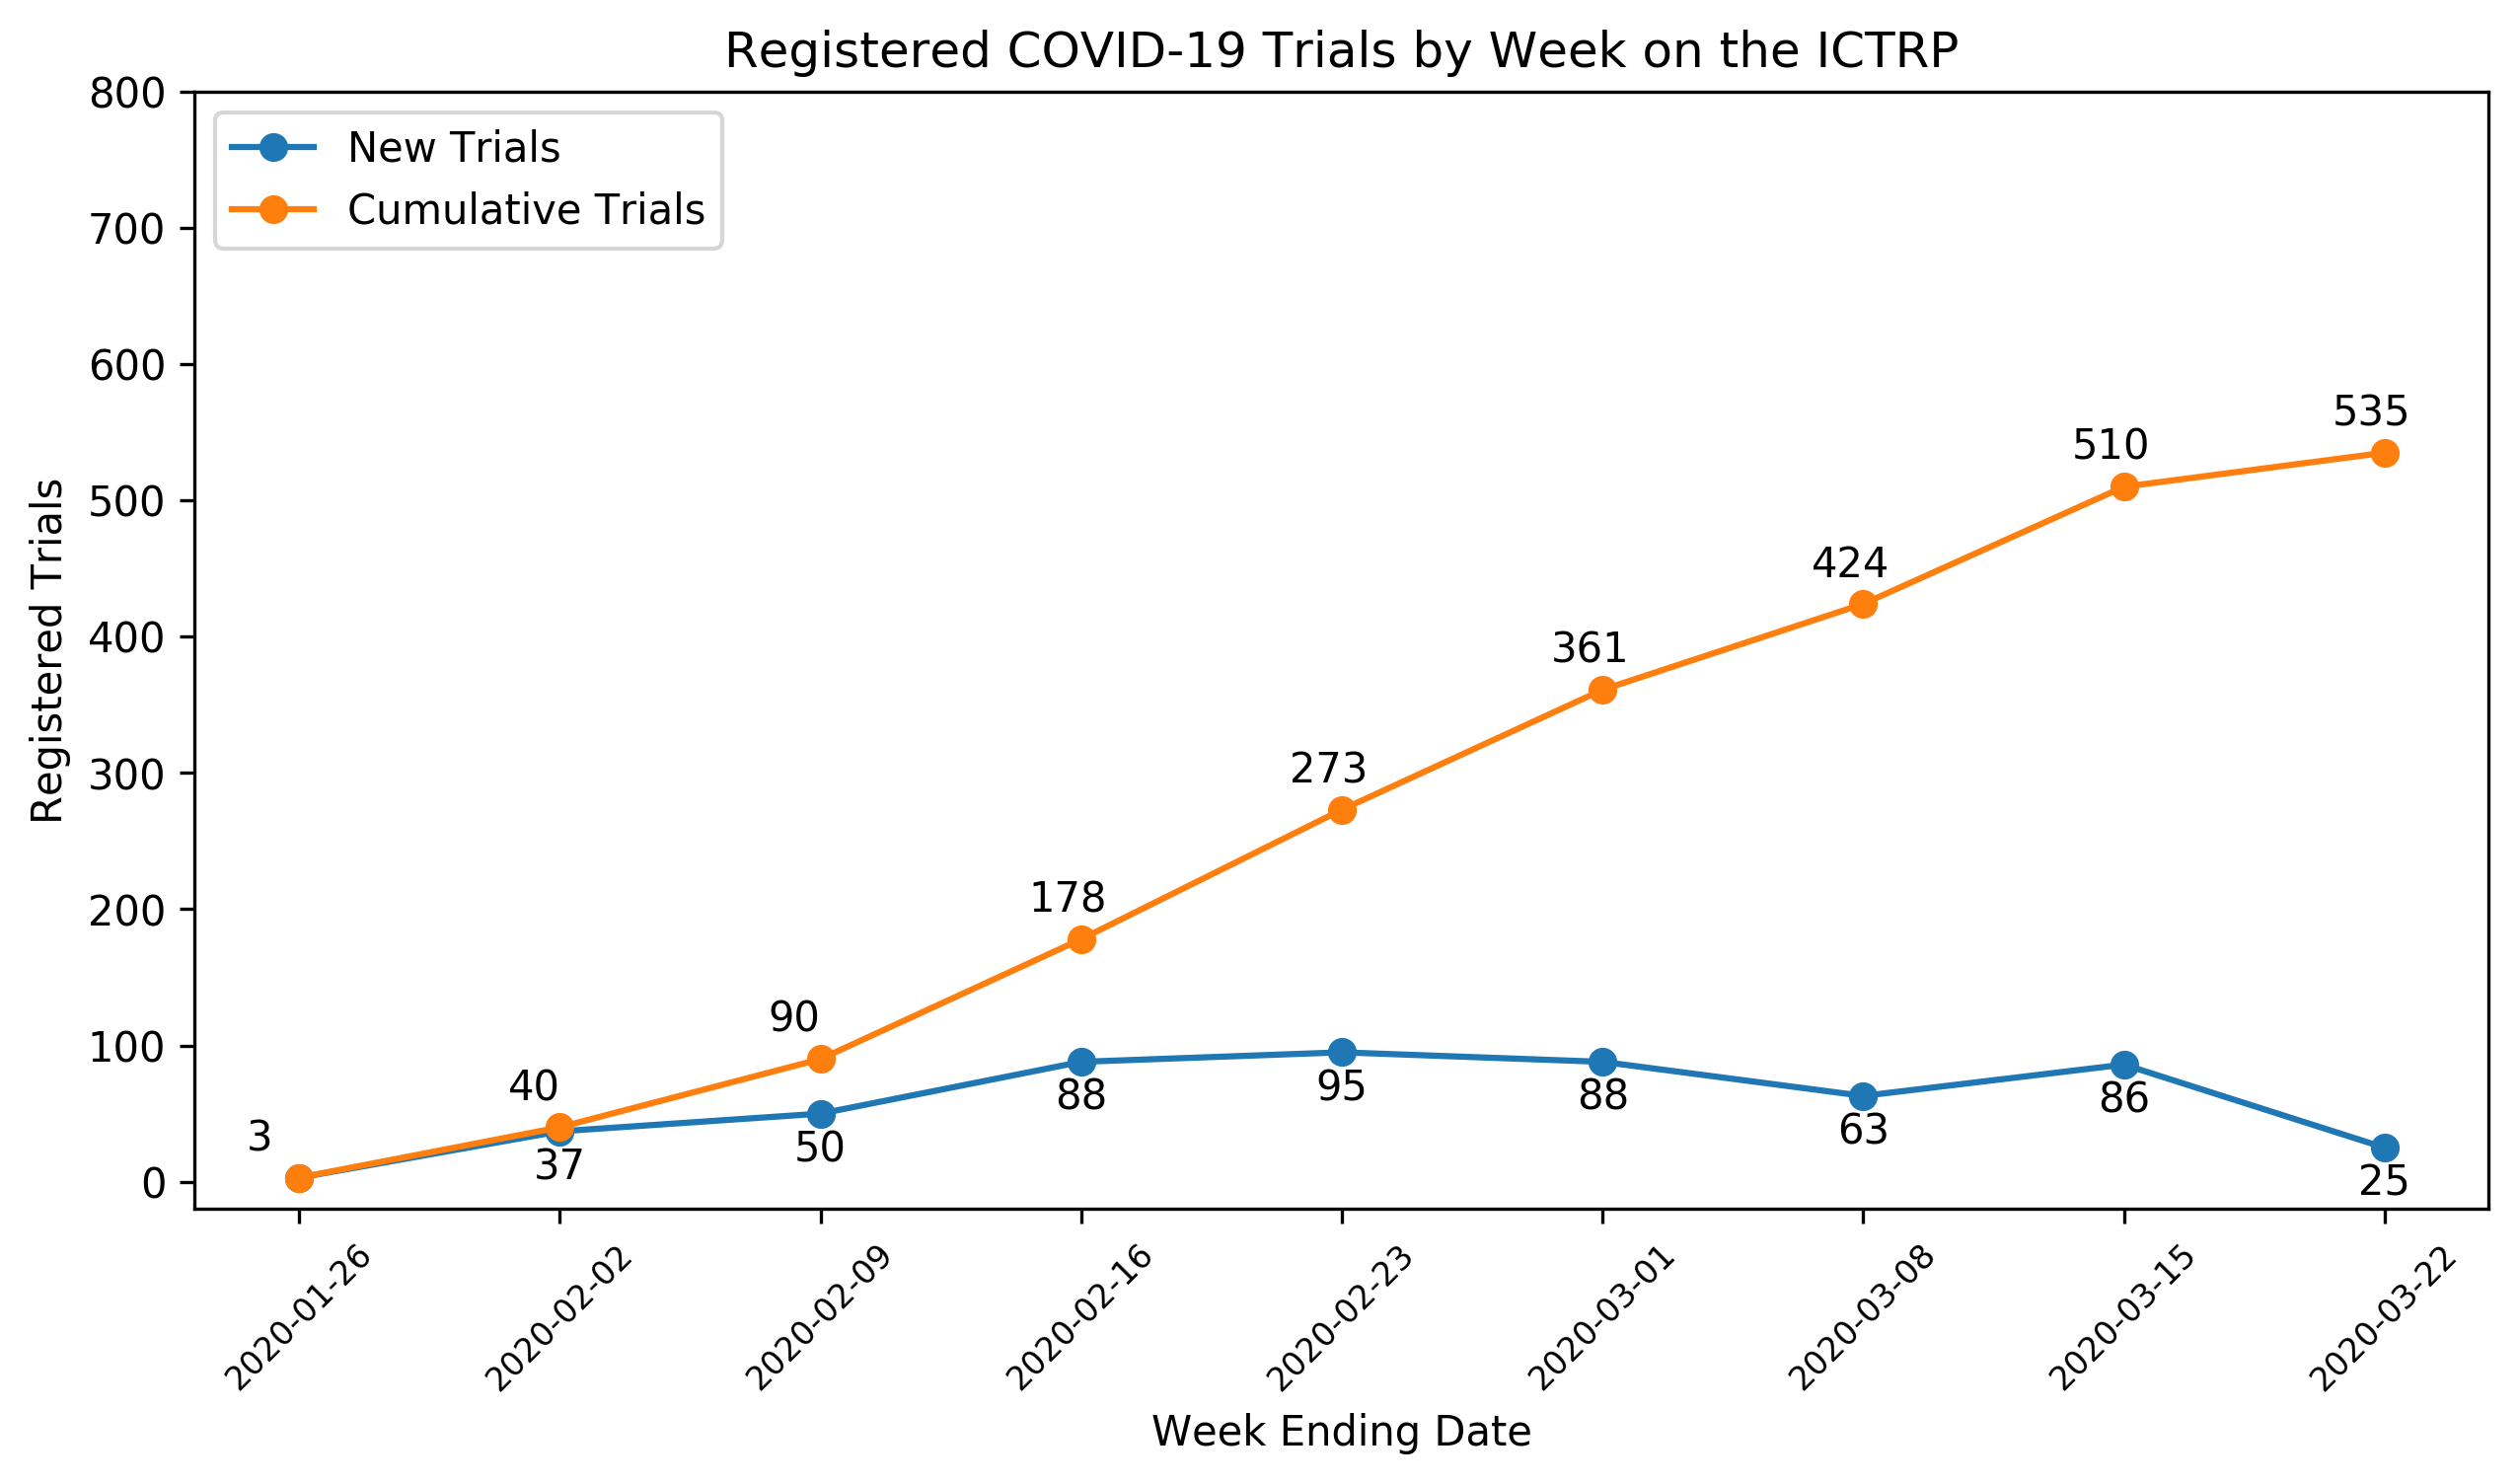

In [27]:
import matplotlib.pyplot as plt

labels = []

for x in list(grouped.index):
    labels.append(str(x.date()))

x_pos = [i for i, _ in enumerate(labels)]

fig, ax = plt.subplots(figsize=(10,5), dpi = 300)

l1 = plt.plot(x_pos, grouped['trialid'], marker = 'o')
l2 = plt.plot(x_pos, cumsum['trialid'], marker = 'o')

for i, j in zip(x_pos[1:], grouped['trialid'].tolist()[1:]):
    ax.annotate(str(j), (i,j), xytext = (i-.1, j-35))

for i, j in zip(x_pos, cumsum['trialid']):
    ax.annotate(str(j), (i,j), xytext = (i-.2, j+20))
    

gr = grouped['trialid'].to_list()
cs = cumsum['trialid'].to_list()

plt.xticks(x_pos, labels, rotation=45, fontsize=8)
plt.ylim(-20,800)
plt.xlabel('Week Ending Date')
plt.ylabel('Registered Trials')
plt.title('Registered COVID-19 Trials by Week on the ICTRP')
plt.legend(('New Trials', 'Cumulative Trials'), loc=2)
#plt.savefig(f'trial_count_{last_extract_date}.png')
plt.show()

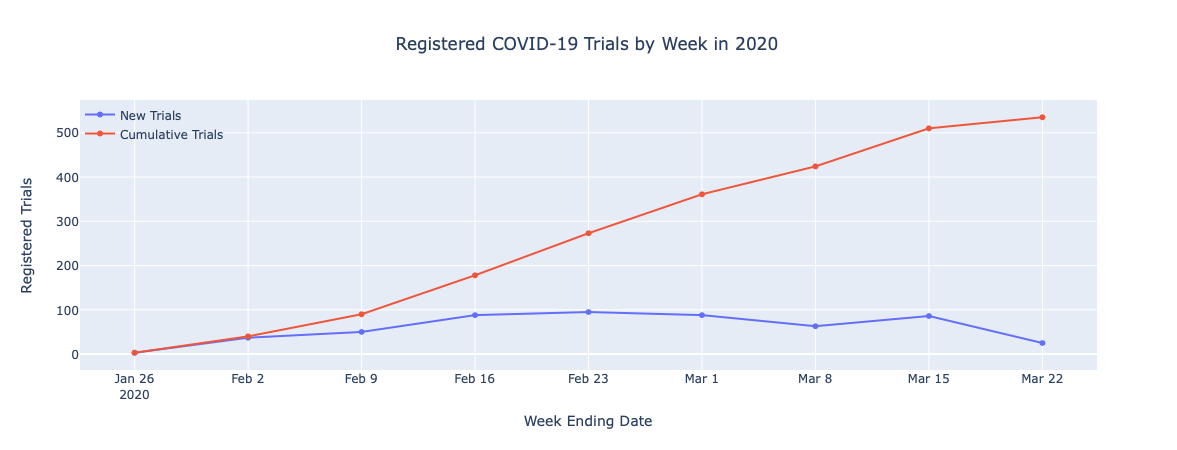

In [39]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=labels, y=grouped['trialid'], fill=None, name='New Trials'))

fig.add_trace(go.Scatter(x=labels, y=cumsum['trialid'], fill=None, name='Cumulative Trials'))

fig.update_layout(title={'text': 'Registered COVID-19 Trials by Week in 2020', 'xanchor': 'center', 'x': 0.5}, 
                  xaxis_title='Week Ending Date',
                  yaxis_title='Registered Trials',
                  legend = dict(x=0, y=1, traceorder='normal', bgcolor='rgba(0,0,0,0)'))



fig.show()
#fig.write_html("registered trials.html")